In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')


In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x.data, y.data

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    

In [4]:
def extract_velocity(eddy_name, eddies):
    edata = eddies[eddy_name]
    
    # Extract middle 30 days
    middle_index = edata.shape[0] // 2
    t0 = extract_number(edata.iloc[middle_index - 15].name) 
    tN = extract_number(edata.iloc[middle_index + 15].name) 
    
    # Initialize arrays
    U1 = np.zeros((lon_rho.shape[0], lon_rho.shape[1], z_r.shape[-1], tN - t0))
    V1 = np.zeros_like(U1)
    
    # Calculate time moduli and file indices
    t_mod0, t_modN = t0 % 30, tN % 30
    file_idx0, file_idxN = int(t0 // 30), int(tN // 30)
    t_pres = 30 - t_mod0
    
    for file_idx in range(file_idx0, file_idxN + 1):
        fnumber = str(f"{1461 + file_idx * 30:05d}")
        
        # Calculate start and end indices
        start_idx = t_mod0 if file_idx == file_idx0 else 0
        end_idx = t_modN if file_idx == file_idxN else 30
        
        # Load data from the file
        U_chunk = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')[:, :, :, start_idx:end_idx]
        V_chunk = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')[:, :, :, start_idx:end_idx]
        
        # Fill data into arrays
        if file_idx == file_idx0:
            U1[:, :, :, :t_pres] = U_chunk
            V1[:, :, :, :t_pres] = V_chunk
        elif file_idx == file_idxN:
            U1[:, :, :, t_pres:] = U_chunk
            V1[:, :, :, t_pres:] = V_chunk
        else:
            U1[:, :, :, t_pres:(t_pres + 30)] = U_chunk
            V1[:, :, :, t_pres:(t_pres + 30)] = V_chunk
            t_pres += 30
    
    # Set invalid data to NaN
    U1 = np.where(np.abs(U1) > 1e30, np.nan, U1)
    V1 = np.where(np.abs(V1) > 1e30, np.nan, V1)
    
    return U1, V1

def interpolate_to_dx_spacing(x, y, Z, dx):
    # Define x and y ranges based on dx
    x_min, x_max = np.round(np.array([np.min(x), np.max(x)]) / dx) * dx
    y_min, y_max = np.round(np.array([np.min(y), np.max(y)]) / dx) * dx

    xy_abs = min(abs(x_min), abs(x_max), abs(y_min), abs(y_max))
    x_new = np.arange(-xy_abs, xy_abs + dx, dx)
    y_new = np.arange(-xy_abs, xy_abs + dx, dx)
    
    # Create the new interpolated Z array with shape (len(y_new), len(x_new), depth_levels)
    depth_levels = Z.shape[2]
    Z_new = np.zeros((len(y_new), len(x_new), depth_levels))
    
    # Interpolate at each depth level
    for k in range(depth_levels):
        original_points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
        values = Z[:, :, k].flatten()
        new_points = np.array(np.meshgrid(x_new, y_new)).T.reshape(-1, 2)
        
        Z_new[:, :, k] = griddata(original_points, values, new_points, method='linear').reshape(len(y_new), len(x_new))
    
    return x_new, y_new, Z_new

def chunk_interpolator(t, U1, V1, depth_lvl_limit):

    t0 = eddies[sample_eddy].shape[0] // 2 - 15
    t_eddy_relative = t + t0
    edata = eddies[sample_eddy].iloc[t_eddy_relative]
    i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
    
    i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
    x_roms, y_roms = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

    _, _, U = interpolate_to_dx_spacing(x_roms, y_roms, U1[i_left:i_right, j_down:j_up,:depth_lvl_limit,t], dx)
    x, y, V = interpolate_to_dx_spacing(x_roms, y_roms, V1[i_left:i_right, j_down:j_up,:depth_lvl_limit,t], dx)

    return {'U': U, 'V': V, 'x': x, 'y': y, 'z': z_r[150, 150, :depth_lvl_limit]}



In [5]:
SEARCH_WIDTH = 300000
dx = 3000

sample_eddies = daydic['Day500'].loc[daydic['Day500']['Age'] > 60].index

the_chosen_eddies = ['Eddy22', 'Eddy110', 'Eddy134', 'Eddy133']

sample_data = {}
for sample_eddy in sample_eddies:
    tic = time.time()
    U1, V1 = extract_velocity(sample_eddy, eddies)

    if sample_eddy in the_chosen_eddies:
        depth_lvl_limit = 30
    else:
        depth_lvl_limit = 23
    
    sample_data[sample_eddy] = {f'T{t}': chunk_interpolator(t, U1, V1, depth_lvl_limit) for t in range(U1.shape[-1])}
    toc = time.time()
    print(f"Elapsed time: {toc - tic:.4f} seconds")
    print(sample_eddy)

Elapsed time: 113.2795 seconds
Eddy739
Elapsed time: 67.0641 seconds
Eddy745
Elapsed time: 66.4061 seconds
Eddy749
Elapsed time: 48.6185 seconds
Eddy761
Elapsed time: 150.4469 seconds
Eddy775
Elapsed time: 130.2031 seconds
Eddy788
Elapsed time: 154.8549 seconds
Eddy790
Elapsed time: 83.5067 seconds
Eddy792
Elapsed time: 56.7475 seconds
Eddy797
Elapsed time: 88.6595 seconds
Eddy827


In [6]:
with open('/srv/scratch/z5297792/Sample/500plus_sample_data.pkl', 'wb') as file:
    pickle.dump(sample_data, file)

In [10]:
def nencioli(u, v, lon, lat, a, b):
    """
    Identify the points in the domain which satisfy the four velocity constraints for eddy detection.

    Parameters:
    - u, v: 2D velocity fields for u and v components
    - lon, lat: Longitude and Latitude matrices
    - mask: Matrix defining sea (1) and land points (0)
    - a, b: Parameters used for constraints

    Returns:
    - eddy_uv: Positions that satisfy the first two constraints (for debugging)
    - eddy_c: Positions satisfying the first three constraints (for debugging)
    - eddy: Positions of the eddy centers with their type (cyclonic=1, anticyclonic=-1)
    """

    borders = max(a, b) + 1

    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)

    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))

    # Get domain dimensions
    bound = vel.shape

    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v

        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]

        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1

            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0

                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0

                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))

                    i1, i2 = int(i1[0]), int(i2[0])
                    
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])

                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                                
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])


    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)

    # Adjust for the Southern Hemisphere (flip cyclonic/anticyclonic labels)
    # eddy[eddy[:, 0] < 0, 2] = -eddy[eddy[:, 0] < 0, 2]
    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy

def moca(u1, v1, u2, v2, n_ic, n_jc, dx):

    def find_increasing_magnitude_sublist(lst, ic, tolerance=0):
        min_radial_dist = 3
        # Initialize sublist and index list with the center element
        sublist = [lst[ic]]
        indices = [ic]
        # Move left and check if magnitude increases with tolerance, at least 3 indices
        count_left = 0
        for i in range(ic - 1, -1, -1):
            if count_left < min_radial_dist:
                sublist.insert(0, lst[i])
                indices.insert(0, i)
                count_left += 1
            elif abs(lst[i]) >= abs(sublist[0]) - tolerance:
                sublist.insert(0, lst[i])
                indices.insert(0, i)
            else:
                break    
        # Move right and check if magnitude increases with tolerance, at least 3 indices
        count_right = 0
        for i in range(ic + 1, len(lst)):
            if count_right < min_radial_dist:
                sublist.append(lst[i])
                indices.append(i)
                count_right += 1
            elif abs(lst[i]) >= abs(sublist[-1]) - tolerance:
                sublist.append(lst[i])
                indices.append(i)
            else:
                break
        return np.array(sublist), indices

    u2, u_ind = find_increasing_magnitude_sublist(u2, n_jc)
    v2 = v2[u_ind]

    yy = (np.array(u_ind) - n_jc) * dx

    v1, v_ind = find_increasing_magnitude_sublist(v1, n_ic)
    u1 = u1[v_ind]
    xx = (np.array(v_ind) - n_ic) * dx

    def polynomial_fit_with_error(x, y, degree=1):
        mask = ~np.isnan(x) & ~np.isnan(y)
        x, y = x[mask], y[mask]
        if degree not in [0, 1]:
            raise ValueError("Degree must be 0 or 1.")
        coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
        y_fit = np.polyval(coefficients, x)
        residuals = y - y_fit
        std_err_coeffs = np.sqrt(np.diag(cov))
        ss_total = np.sum((y - np.mean(y))**2)
        ss_residuals = np.sum(residuals**2)
        r_squared = 1 - (ss_residuals / ss_total)
        return coefficients, std_err_coeffs, r_squared
    
    As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
    A1, A0 = As
    Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
    B1, B0 = Bs
    Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
    C1, C0 = Cs
    Ds, DAs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
    D1, D0 = Ds
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    Q = np.array([[q11, q12], [q12, q22]])
    def is_pos_def(Q):
        eigenvalues = np.linalg.eigvals(Q)
        return np.all(eigenvalues > 0)
    if is_pos_def(Q) or is_pos_def(-Q):
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
    else:
        xc = yc = np.nan

    return xc, yc

def tilt_distance(x, y):
    if np.all(np.isnan(x)):
        return np.nan
    else:
        return np.sqrt( (np.nanmax(x)-np.nanmin(x))**2 + (np.nanmax(y)-np.nanmin(y))**2 )
        

In [11]:
MAX_DISPLACEMENT = 50000
for eddy in sample_eddies:
    start_time = time.time()
    var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1
    for t in range(30):
        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        x = sample_data[eddy]['T'+str(t)]['x']
        y = sample_data[eddy]['T'+str(t)]['y']
        dx = x[1] - x[0]

        a, b = 6, 5
        xcs, ycs, zcs = [], [], []
        flag = 1
        for depth_lvl in range(U.shape[-1]):
            if flag:
                u = U[:, :, depth_lvl]
                v = V[:, :, depth_lvl]
                X, Y = np.meshgrid(x, y)
                neddy_uv, neddy_c, neddy = nencioli(u.T, v.T, X, Y, a, b)
                
                neddy = neddy[neddy[:, 2] == var]

                if len(neddy[:, 1]) > 1:
                    if depth_lvl == 0:
                        R = np.sqrt(neddy[:, 1]**2 + neddy[:, 0]**2)
                    else:
                        R = np.sqrt((xcs[-1]-neddy[:, 1])**2 + (ycs[-1]-neddy[:, 0])**2)
                    neddy = neddy[R == np.nanmin(R)]
                    
                if len(neddy[:, 1]) == 1:

                    n_xc, n_yc = neddy[0, 1], neddy[0, 0] #takign 1st one
                    n_ic = np.where(n_xc == x)[0][0]
                    n_jc = np.where(n_yc == y)[0][0]
                    
                    u1 = u[:, n_jc].squeeze()
                    v1 = v[:, n_jc].squeeze()
                
                    u2 = u[n_ic, :].squeeze()
                    v2 = v[n_ic, :].squeeze()
        
                    xc, yc = moca(u1, v1, u2, v2, n_ic, n_jc, dx)
                    if depth_lvl == 0:
                        R = MAX_DISPLACEMENT - 10
                    else:
                        R = np.sqrt((xcs[-1]-(n_xc + xc))**2 + (ycs[-1]-(n_yc + yc))**2)
                    if R <= MAX_DISPLACEMENT:
                        xcs.append(n_xc + xc)
                        ycs.append(n_yc + yc)
                        zcs.append(z_r[150, 150, depth_lvl])
                    else:
                        flag = 0
                else:
                    flag = 0
                
        if len(xcs) == 0:
            xcs = ycs = zcs = [np.nan]
        sample_data[eddy]['T'+str(t)]['VG'] = pd.DataFrame({
            'x': xcs,
            'y': ycs,
            'Depth': zcs,
            'TD': [tilt_distance(xcs, ycs)] * len(xcs)
        })
    end_time = time.time()
    print(eddy)
    print(f"Elapsed time: {end_time - start_time} seconds")

Eddy739
Elapsed time: 3.4870522022247314 seconds
Eddy745
Elapsed time: 2.7647290229797363 seconds
Eddy749
Elapsed time: 2.554622173309326 seconds
Eddy761
Elapsed time: 1.8373119831085205 seconds
Eddy775
Elapsed time: 2.774834156036377 seconds
Eddy788
Elapsed time: 2.1132290363311768 seconds
Eddy790
Elapsed time: 3.505573034286499 seconds
Eddy792
Elapsed time: 3.944596290588379 seconds
Eddy797
Elapsed time: 1.6413342952728271 seconds
Eddy827
Elapsed time: 1.9701471328735352 seconds


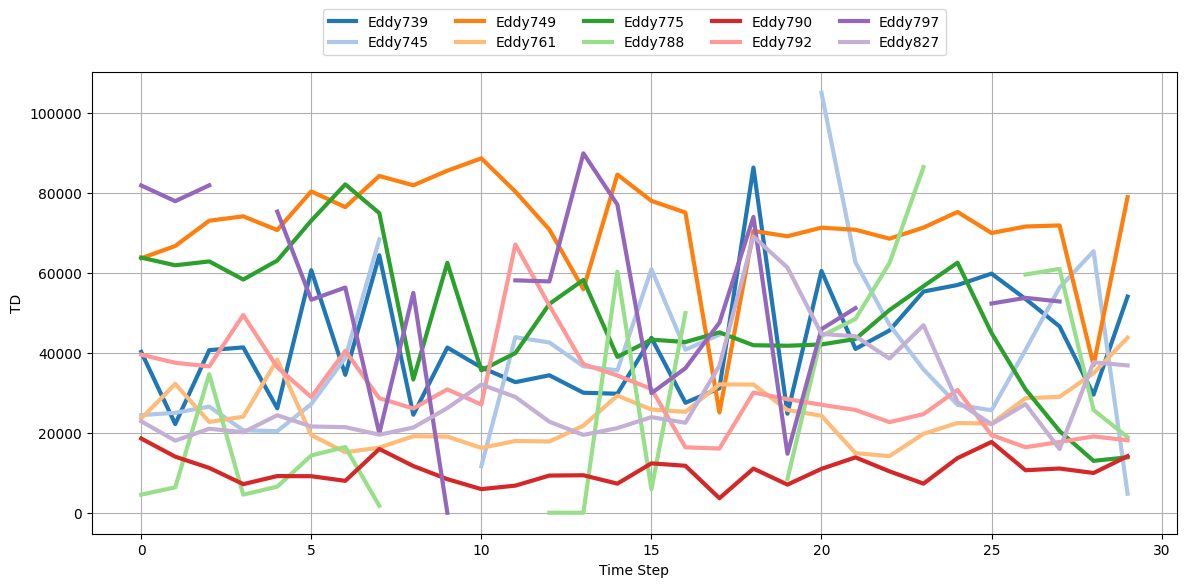

,TD
Eddy790,10570.340391
Eddy761,24253.119656
Eddy827,29862.717565
Eddy792,30499.972293
Eddy788,30830.896765
Eddy745,39918.944846
Eddy739,42500.481521
Eddy775,48461.536695
Eddy797,54018.600522
Eddy749,71355.953669


In [14]:
plt.figure(figsize=(14, 6))

cmap = plt.colormaps['tab20']
TD_mean = []
for i, sample_eddy in enumerate(sample_eddies):
    TD = []
    for t in range(30):
        TD.append(sample_data[sample_eddy]['T'+str(t)]['VG']['TD'][0])
    plt.plot(np.arange(30), TD, label=sample_eddy, linewidth=3, color=cmap(i))
    TD_mean.append(np.nanmean(TD))
df = pd.DataFrame({'TD': TD_mean})
df.index = sample_eddies

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(sample_eddies) // 2)
plt.xlabel('Time Step')
plt.ylabel('TD')
plt.grid()
plt.show()

df = df.sort_values(by="TD", ascending=True)
df

In [15]:
the_chosen_eddies = ['Eddy749', 'Eddy790', 'Eddy775', 'Eddy761']

,Lon,Lat,Vort,Id,Age
Day432,161.912663,-28.719461,-0.000010,749.0,75
Day433,161.854716,-28.700964,-0.000014,749.0,75
Day434,161.885532,-28.804159,-0.000007,749.0,75
Day435,161.755944,-28.809515,-0.000010,749.0,75
Day436,161.670683,-28.875716,-0.000010,749.0,75
...,...,...,...,...,...
Day502,158.817825,-30.828490,-0.000015,749.0,75
Day503,158.842951,-30.930050,-0.000012,749.0,75
Day504,158.814113,-31.014748,-0.000011,749.0,75
Day505,158.785273,-31.099446,-0.000009,749.0,75
